In [60]:
import pandas as pd
import numpy as np
from scipy.signal import welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import gridspec
import mne

In [61]:
patient_num = 2

eeg_task_path = f'../Data/Processed/sub0{patient_num}_binned_task.csv'
eeg_data = pd.read_csv(eeg_task_path)

In [62]:
bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 50)
}

selected_electrodes = [
    'O1', 'O2', 'Oz', 'POz', 'PO3', 'PO4', 'PO7', 'PO8',
    'F3', 'F4', 'Fz', 'F7', 'F8', 'AF3', 'AF4', 'AF7', 'AF8', 'Fpz',
    'T7', 'T8', 'Cz', 'Pz', 'FCz', 'CP1', 'CP2'
]

In [63]:
def compute_band_power(eeg_data, sfreq, bands):
    band_powers = []
    electrode_data = eeg_data.drop(columns=['label', 'label_type'])
    for index, row in electrode_data.iterrows():
        features = {}
        for electrode in selected_electrodes:
            # Convert the string list in each cell to a real list of floats
            signal = np.array(eval(row[electrode]))  
            freqs, psd = welch(signal, sfreq, nperseg=sfreq*2)
            
            # Compute band power for each defined band
            for band, (low, high) in bands.items():
                band_power = np.sum(psd[(freqs >= low) & (freqs <= high)])
                features[f'{electrode}_{band}'] = band_power
        
        band_powers.append(features)
    return pd.DataFrame(band_powers)

In [64]:
def extract_feature_importances(rf_model, band_power_df, selected_electrodes, bands):
    feature_importances = rf_model.feature_importances_
    band_importances = {band: {electrode: 0 for electrode in selected_electrodes} for band in bands}
    
    # Loop through each band and compute the average importance for each electrode
    for band in bands:
        band_columns = [col for col in band_power_df.columns if f'_{band}' in col]
        band_feature_importances = feature_importances[[band_power_df.columns.get_loc(col) for col in band_columns]]
        
        for electrode in selected_electrodes:
            importance_values = [band_feature_importances[i] for i, col in enumerate(band_columns) if col.startswith(electrode)]
            band_importances[band][electrode] = np.mean(importance_values)
    
    return band_importances

In [65]:
def plot_combined_topomap(band_importances, selected_electrodes):
    """
    Plot topographical scalp maps for each frequency band in a single figure with a shared colorbar.
    """
    montage = mne.channels.make_standard_montage('standard_1020')
    info = mne.create_info(ch_names=selected_electrodes, sfreq=512, ch_types='eeg')
    info.set_montage(montage)
    
    n_bands = len(band_importances)
    
    # Create a figure with gridspec to allocate space for the colorbar
    fig = plt.figure(figsize=(20, 5))
    gs = gridspec.GridSpec(1, n_bands + 1, width_ratios=[1] * n_bands + [0.05], wspace=0.4)
    
    # Concatenate all feature importances to find global min and max for normalization
    all_importances = np.concatenate([list(importance.values()) for importance in band_importances.values()])
    global_min, global_max = 0, np.max(all_importances)
    
    axes = []
    for idx, (band, importance) in enumerate(band_importances.items()):
        ax = fig.add_subplot(gs[0, idx])
        axes.append(ax)
        
        # Normalize the importance values for the current band
        importance_array = np.array([importance.get(ch, 0) for ch in selected_electrodes])
        normalized_importance = (importance_array - global_min) / (global_max - global_min)
        
        # Plot the topographical map for the current band
        im, _ = mne.viz.plot_topomap(
            normalized_importance, info, axes=ax, cmap='viridis', show=False
        )
        ax.set_title(f'{band.title()} Band', fontsize=14)
    
    # Add a colorbar in the last column of the gridspec
    cbar_ax = fig.add_subplot(gs[0, -1])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
    cbar.set_label('Feature Importance')

    plt.suptitle('Topographical Maps of Feature Importances by Frequency Band', fontsize=16)
    plt.show()

Random Forest accuracy: 1.00


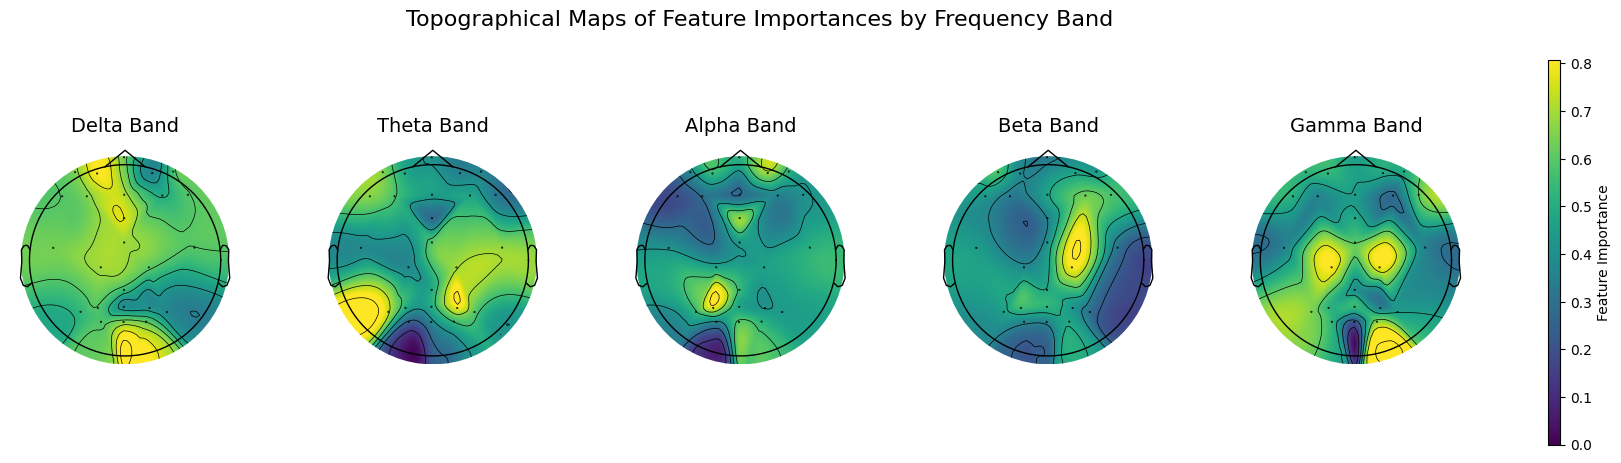

In [66]:
# Compute band power features
band_power_df = compute_band_power(eeg_data, sfreq=512, bands=bands)

labels = eeg_data['label_type'].apply(lambda x: 1 if x == 'social' else 0)

X_train, X_test, y_train, y_test = train_test_split(band_power_df, labels, test_size=0.3, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(band_power_df, labels)

# Evaluate the model (Optional)
accuracy = rf_model.score(X_test, y_test)
print(f'Random Forest accuracy: {accuracy:.2f}')

# Extract feature importances for each band
band_importances = extract_feature_importances(rf_model, band_power_df, selected_electrodes, bands)

# Plot topographical maps for each band
plot_combined_topomap(band_importances, selected_electrodes)